# Data exploration

In [3]:
import igraph as ig
import leidenalg as la
import json
import pandas as pd
import numpy as np

edge_dict = []
index = 1
with open('./data/roads_graph.txt') as f:
    for line in f:
        adjacency_list = str.split(line, ' ')
        edge_dict.append((int(adjacency_list[0]), int(adjacency_list[1])))
        index += 1

edge_matrix = pd.DataFrame(columns=('Source','Target'), data=edge_dict)

def parse_shenzen_info(filename):
    vertex_info = []
    with open(filename) as f:
        json_file = json.load(f)
    for example in json_file['features']:
        properties = example['properties']
        vertex_info.append(properties['speed'])
    return vertex_info

vertex_info_roads = np.array(parse_shenzen_info('./data/shenzhen_roads.geojson')).reshape(-1, 1).tolist()

g = ig.Graph.DataFrame(edge_matrix, directed=False)

kwargs = {
    'node_attributes':vertex_info_roads,
    'resolution_parameter':0.5
}
# partition = la.find_partition(g, la.ContiguousConstrainedVertexPartition, **kwargs)

# Some metrics
# print(f'Original graph: {g.vcount()} elements')
# print(part.summary())
# print(f'Partition quality: {part.quality()}')

In [5]:
np.min(vertex_info_roads)

3.9548159121569624

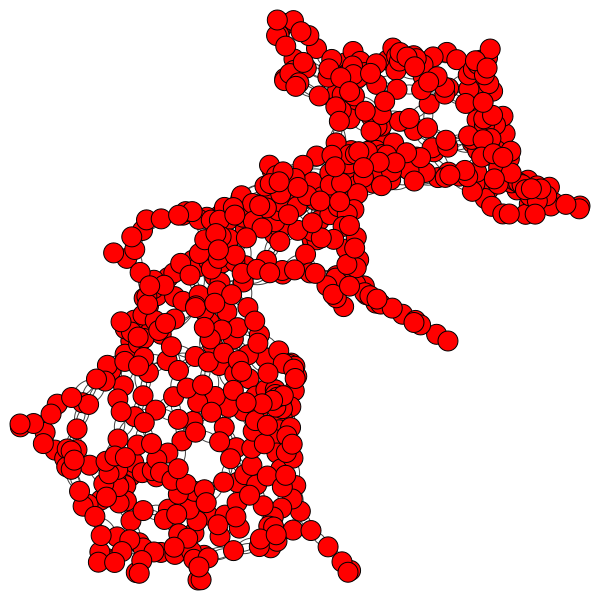

In [2]:
ig.plot(g)

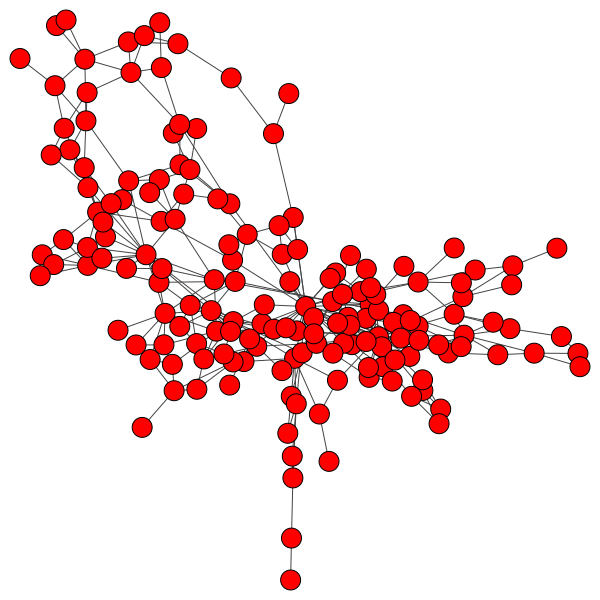

In [3]:
ig.plot(partition.cluster_graph())

In [2]:
import matplotlib as pyplot
sizes_df = pd.DataFrame(data=partition.sizes(), columns=['Size'])
sizes_df.value_counts()

Size
1       104
2        82
3        44
4        27
6         8
5         5
7         3
8         2
dtype: int64

In [3]:
import numpy as np

def convert_edge_matrix_to_connectivity_matrix():
  num_elements = edge_matrix['Source'].max()
  matrix = np.zeros((num_elements + 1, num_elements + 1))
  for (_, row) in edge_matrix.iterrows():
    target_row = row['Source']
    target_col = row['Target']
    matrix[target_row, target_col] = 1
  return matrix

connectivity_matrix = convert_edge_matrix_to_connectivity_matrix()

In [4]:
num_clusters = len(partition.sizes())

In [5]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', metric='euclidean', connectivity=connectivity_matrix, compute_distances=True)
X = np.array(vertex_info_roads).reshape(-1, 1)
clusters = agg_clustering.fit(X)


In [6]:
squared_vertex_info = [val*val for val in vertex_info_roads]

In [7]:
output_df = pd.DataFrame(data={'Speed':vertex_info_roads, 'Squared_Speed':squared_vertex_info, 'Cluster_Agglomerative':clusters.labels_, 'Cluster_Contiguity':partition.membership})

In [1]:
output_df

NameError: name 'output_df' is not defined

<Axes: >

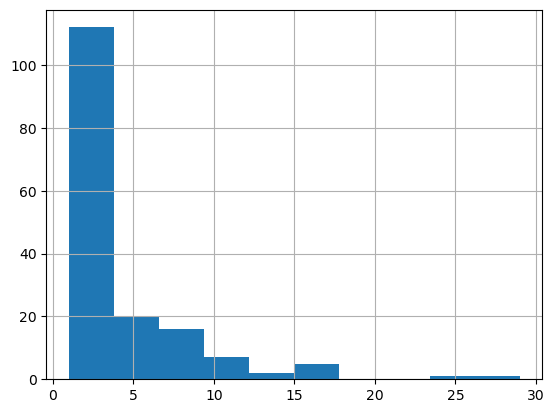

In [11]:
output_df.groupby('Cluster_Agglomerative').size().hist()

<Axes: >

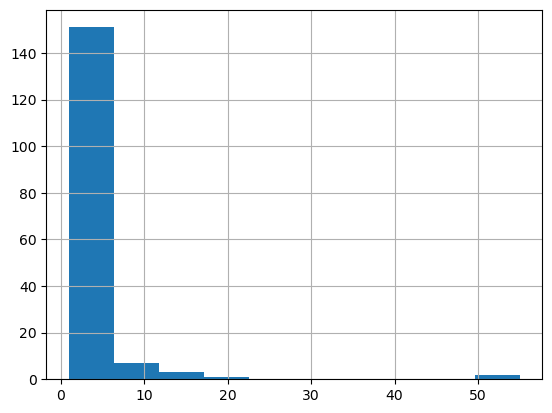

In [12]:
output_df.groupby('Cluster_Contiguity').size().hist()

In [14]:
output_df.groupby('Cluster_Contiguity').var().sum()['Speed']

87.09584994589463

In [16]:
output_df.groupby('Cluster_Agglomerative').var().sum()['Speed']

15.062933601294635

In [24]:
output_df.groupby('Cluster_Contiguity')['Speed']

0        5.011831
1       14.367472
2        9.584904
3       10.905286
4        7.287700
          ...    
613    441.897695
614     43.531734
615     53.955662
616     51.707437
617     61.272259
Name: Speed, Length: 618, dtype: float64

In [56]:
test_df = pd.DataFrame({
    'Speed': [3, 4, 5, 10, 15, 20, 3, 7, 2],
    'Squared_Speed':[9, 16, 25, 100, 125, 400, 9, 49, 4],
    'Cluster_Contiguity':[1, 1, 1, 0, 0, 0, 2, 2, 2]
})
test_df

,Speed,Squared_Speed,Cluster_Contiguity
0,3,9,1
1,4,16,1
2,5,25,1
3,10,100,0
4,15,125,0
5,20,400,0
6,3,9,2
7,7,49,2
8,2,4,2


In [50]:
(9 + 16 + 25) - (((3+4+5)*(3+4+5))/3)

2.0

In [52]:
(100+125+400) - (((10+15+20)*(10+15+20))/3)

-50.0

In [57]:
(9+49+4) - (((3+7+2)*(3+7+2))/3)

14.0

In [59]:
grouped = output_df.groupby('Cluster_Contiguity')
feature_sum = grouped['Speed'].sum()
squared_feature_sum = grouped['Squared_Speed'].sum()
weighted_variance = squared_feature_sum - ((feature_sum * feature_sum) / grouped.size())
weighted_variance.sum()

919.3673678237985

In [61]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Evaluate Silhouette Score
silhouette = silhouette_score(X, output_df['Cluster_Agglomerative'])

# Evaluate Calinski-Harabasz Index
calinski = calinski_harabasz_score(X, output_df['Cluster_Agglomerative'])

# Evaluate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, output_df['Cluster_Agglomerative'])

# Print the evaluation results
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski}")
print(f"Davies-Bouldin Index: {davies_bouldin}")


Silhouette Score: -0.72525728088182
Calinski-Harabasz Index: 141.7559352573429
Davies-Bouldin Index: 64.6825311197564


In [8]:
partition.set_membership(clusters.labels_)

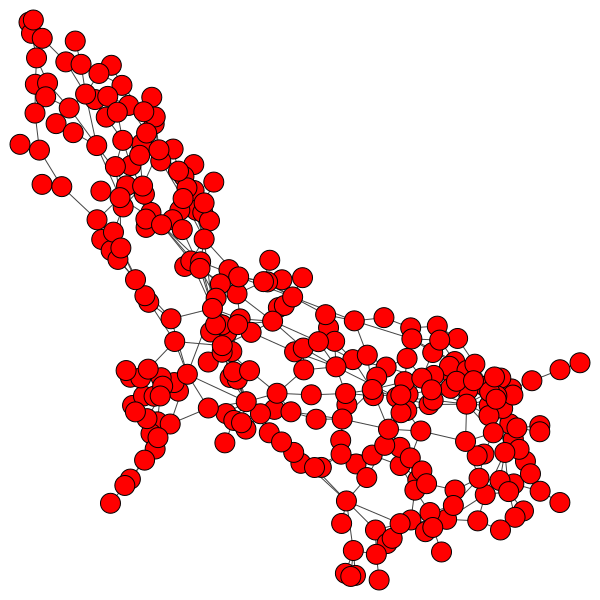

In [9]:
ig.plot(partition.cluster_graph())

# Evaluating Contiguity Clustering Method

In [1]:
import igraph as ig
import leidenalg
import json
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import timeit

def parse_shenzen_info():
    edge_dict = []
    with open('./data/roads_graph.txt') as f:
        for line in f:
            adjacency_list = str.split(line, ' ')
            edge_dict.append((int(adjacency_list[0]), int(adjacency_list[1])))

    vertex_info = []
    index = 0
    with open('./data/shenzhen_roads.geojson') as f:
        json_file = json.load(f)
    for example in json_file['features']:
        properties = example['properties']
        vertex_info.append(properties['speed'])
        index+=1
    
    return edge_dict, vertex_info

def analyze_per_move_history(per_move_history, iteration):
    history = []

    for i in range(0, len(per_move_history), 6):
        
        move_type = ''
        if per_move_history[i] == 0.0:
            move_type = 'move'
        elif per_move_history[i] == 1.0:
            move_type = 'merge'
        elif per_move_history[i] == 2.0:
            move_type = 'move_constrained'
        elif per_move_history[i] == 3.0:
            move_type = 'merge_constrained'
        
        phase = ''
        if (per_move_history[i+1] > 0.0):
            phase = f'move_phase_{per_move_history[i+1]}'
        elif (per_move_history[i+1] < 0.0):
            phase = f'refine_phase_{per_move_history[i+1] * -1}'

        history.append(
            {
                'move_type':move_type,
                'phase':phase,
                'node_id':per_move_history[i+2],
                'from_community_id':per_move_history[i+3],
                'to_community_id':per_move_history[i+4],
                'diff_move':per_move_history[i+5],
                'iteration':iteration,
            }
        )
    return history

def convert_edge_matrix_to_connectivity_matrix(edge_matrix):
  num_elements = max(edge_matrix['Source'].max(), edge_matrix['Target'].max())
  matrix = np.zeros((num_elements + 1, num_elements + 1))
  for (_, row) in edge_matrix.iterrows():
    target_row = row['Source']
    target_col = row['Target']
    matrix[target_row, target_col] = 1
  return matrix

def calculate_weighted_variance(grouped):
    feature_sum = grouped['Speed'].sum()
    squared_feature_sum = grouped['Squared_Speed'].sum()
    weighted_variance = squared_feature_sum - ((feature_sum * feature_sum) / grouped.size())
    return weighted_variance.sum()

def get_subgraphs_by_clusters(edge_matrix_df, partition):
    subgraphs = {}
    for (comm, count) in enumerate(partition.sizes()):
        subgraphs[comm] = []
        for (vertex, v_comm) in enumerate(partition.membership):
            if (comm == v_comm):
                subgraphs[comm].append(vertex)
        if (len(subgraphs[comm]) != count):
            raise Exception("Counts do not match")
    
    subgraph_edge_matrices = {}
    for (subgraph, vertices) in subgraphs.items():
        matrix = []
        for (index, vertex) in enumerate(vertices):
            edges = edge_matrix_df[edge_matrix_df['Source'] == vertex]
            for row in edges.iterrows():
                source = row[1]['Source']
                target = row[1]['Target']
                if target in vertices:
                    index_of_target = vertices.index(target)
                    if (matrix.count((index_of_target, index)) > 0):
                        continue
                    matrix.append((index, index_of_target))
        subgraph_edge_matrices[subgraph] = matrix
        
    return subgraph_edge_matrices, subgraphs

def find_disconnected_communities(results_map):
    subgraph_edges, subgraph_vertices = get_subgraphs_by_clusters(results_map['Edge_Matrix_DF'], results_map['Partition'])
    for graph_number in range(len(results_map['Partition'])):
        edge_list = subgraph_edges[graph_number]
        vertex_list = subgraph_vertices[graph_number]
        subgraph = ig.Graph(n=len(vertex_list), edges=edge_list, directed=False)
        if (not subgraph.is_connected()):
            print(f"Subgraph {graph_number} is NOT connected")

def perform_agglomerative_clustering(edge_matrix, node_attributes, num_clusters):
    connectivity_matrix = convert_edge_matrix_to_connectivity_matrix(edge_matrix)
    agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward', metric='euclidean', connectivity=connectivity_matrix, compute_distances=True)
    clusters = agg_clustering.fit(node_attributes)
    return clusters

def compare_clustering_result(param, node_attributes, partition, clusters: AgglomerativeClustering):
    flattened_attributes = np.array(node_attributes).flatten()
    squared_speed = flattened_attributes ** 2
    output_df = pd.DataFrame(
        data={
            'Speed':flattened_attributes, 
            'Squared_Speed':squared_speed, 
            'Cluster_Agglomerative':clusters.labels_, 
            'Cluster_Contiguity':partition.membership
        }
    )

    var_speed_by_contigs = calculate_weighted_variance(output_df.groupby('Cluster_Contiguity'))
    var_speed_by_aggloms = calculate_weighted_variance(output_df.groupby('Cluster_Agglomerative'))

    silhouette_contigs = silhouette_score(node_attributes, output_df['Cluster_Contiguity'])
    calinski_contigs = calinski_harabasz_score(node_attributes, output_df['Cluster_Contiguity'])
    davies_bouldin_contigs = davies_bouldin_score(node_attributes, output_df['Cluster_Contiguity'])

    silhouette_agglom = silhouette_score(node_attributes, output_df['Cluster_Agglomerative'])
    calinski_agglom = calinski_harabasz_score(node_attributes, output_df['Cluster_Agglomerative'])
    davies_bouldin_agglom = davies_bouldin_score(node_attributes, output_df['Cluster_Agglomerative'])

    print('-'* 100) 
    print(f'Clustering Analysis')
    print('-'* 100) 
    print(partition.summary())
    print(f'Partition quality: {-(partition.quality() + (param * len(partition)))}')
    print(f'Weighted speed variance of contiguity based clusters:    {var_speed_by_contigs}')
    print(f"Silhouette Score: {silhouette_contigs}")
    print(f"Calinski-Harabasz Index: {calinski_contigs}")
    print(f"Davies-Bouldin Index: {davies_bouldin_contigs}")
    print('-'* 100) 
    print(f'Agglomerative clustering on {clusters.n_clusters_} clusters: ')
    print(f'Sum of distances: {sum(clusters.distances_)}')
    print(f'Weighted speed variance of agglomerative based clusters: {var_speed_by_aggloms}')
    print(f"Silhouette Score: {silhouette_agglom}")
    print(f"Calinski-Harabasz Index: {calinski_agglom}")
    print(f"Davies-Bouldin Index: {davies_bouldin_agglom}")
    return output_df

def manually_optimize_partition(edge_matrix, node_attributes, resolution_parameter, disconnect_penalty, n_iterations):
    graph = ig.Graph.DataFrame(
        edges=edge_matrix, 
        directed=False, 
    )
    kwargs = {
        'node_attributes':node_attributes,
        'resolution_parameter':resolution_parameter,
        'disconnect_penalty':disconnect_penalty,
    }
    partition = leidenalg.ContiguousConstrainedVertexPartition(graph, **kwargs)
    optimiser = leidenalg.Optimiser()
    optimiser.set_rng_seed(42)

    historic_raw_qualities = []
    historic_qualities = []
    historic_community_weights = []
    historic_diffs = []
    move_history = []
    collapse_history = []

    raw_quality = partition.quality() * -1
    num_clusters = len(partition)
    community_weight = num_clusters * resolution_parameter
    adjusted_quality = raw_quality + community_weight

    historic_raw_qualities.append(raw_quality)
    historic_qualities.append(adjusted_quality)
    historic_community_weights.append(num_clusters)
    historic_diffs.append(0)
    
    itr = 0 
    diff = 0
    continue_iteration = itr < n_iterations or n_iterations < 0
    while continue_iteration:
        
        diff_inc = leidenalg._c_leiden._Optimiser_optimise_partition(
            optimiser._optimiser,
            partition._partition,
        )   
        itr += 1
        raw_quality = partition.quality() * -1
        num_clusters = len(partition)
        community_weight = num_clusters * resolution_parameter
        adjusted_quality = raw_quality + community_weight
        diff += diff_inc

        historic_raw_qualities.append(raw_quality)
        historic_qualities.append(adjusted_quality)
        historic_community_weights.append(num_clusters)
        historic_diffs.append(diff_inc)

        # per_collapse_history_this_iteration = optimiser.get_optimization_history_per_collapse()
        # collapse_history.extend(per_collapse_history_this_iteration)
        # per_move_history_this_iteration = analyze_per_move_history(optimiser.get_optimization_history_per_move(), itr)
        # move_history.extend(per_move_history_this_iteration)

        if n_iterations < 0:
            continue_iteration = (diff_inc > 0)
        else:
            continue_iteration = itr < n_iterations

    partition._update_internal_membership()
    return partition, optimiser, historic_raw_qualities, historic_qualities, historic_community_weights, historic_diffs, collapse_history, move_history

import igraph as ig
import leidenalg
from sklearn.preprocessing import StandardScaler

def compare_leiden_algorithm():
    edge_map, node_attributes = parse_shenzen_info()
    edge_matrix = pd.DataFrame(columns=('Source','Target'), data=edge_map)
    scaler = StandardScaler()
    node_attributes = np.array(node_attributes).reshape(-1, 1)
    X = scaler.fit_transform(node_attributes)
    squared_attr = X ** 2
  
    graph = ig.Graph.DataFrame(edge_matrix, directed=False)
    output_df = pd.DataFrame({'Speed':X[:, 0], 'Squared_Speed':squared_attr[:, 0]})
    partition = leidenalg.find_partition(graph=graph, partition_type=leidenalg.CPMVertexPartition, n_iterations=-1, **{'resolution_parameter':.003})
    output_df['Clusters'] = partition.membership
    print(len(partition))
    print(calculate_weighted_variance(output_df.groupby('Clusters')))

def get_shenzen_clustering_results(params):
    edge_map, node_attributes = parse_shenzen_info()
    edge_matrix = pd.DataFrame(columns=('Source','Target'), data=edge_map)
    scaler = StandardScaler()
    node_attributes = np.array(node_attributes).reshape(-1, 1).tolist()
    X = scaler.fit_transform(node_attributes).tolist()
    
    results = {}

    for param in params:
        partition, optimiser, raw_quality, qualities, community_weights, diffs, collapse_history, move_history = manually_optimize_partition(
            edge_matrix=edge_matrix, 
            node_attributes=X, 
            resolution_parameter=param,
            disconnect_penalty=0,
            n_iterations=-1
        )
        clustering = perform_agglomerative_clustering(edge_matrix=edge_matrix, node_attributes=X, num_clusters=len(partition.sizes()))
        output_df = compare_clustering_result(param, X, partition=partition, clusters=clustering)
        results[param] = {
            'Partition':partition, 
            'Optimiser': optimiser,
            'Clustering':clustering, 
            'Raw_Quality':raw_quality, 
            'Adjusted_Quality':qualities, 
            'Community_Weight':community_weights, 
            'Diffs':diffs,
            'Output_DF':output_df,
            'Collapse_History':collapse_history,
            'Move_History':move_history,
            'Edge_Matrix_DF':edge_matrix
        }
    
    return results


In [10]:
compare_leiden_algorithm()

5
533.4196030572652


In [79]:
param = 10
contiguity_clustering_results = get_shenzen_clustering_results([param])

----------------------------------------------------------------------------------------------------
Clustering Analysis
----------------------------------------------------------------------------------------------------
Clustering with 618 elements and 8 clusters
Partition quality: 182.0394820751335
Weighted speed variance of contiguity based clusters:    182.03948207513366
Silhouette Score: -0.038673305944624765
Calinski-Harabasz Index: 208.6956340480719
Davies-Bouldin Index: 4.2489751779214995
----------------------------------------------------------------------------------------------------
Agglomerative clustering on 8 clusters: 
Sum of distances: 350.4359874664629
Weighted speed variance of agglomerative based clusters: 204.6072529874296
Silhouette Score: -0.06444083587135024
Calinski-Harabasz Index: 176.06523996987985
Davies-Bouldin Index: 3.6629696774629563


In [10]:
import geopandas as gpd
import fiona

gdf = gpd.read_file('./data/shenzhen_roads.geojson')
gdf['Cluster_Contiguity'] = contiguity_clustering_results[param]['Partition'].membership
gdf['Cluster_Agglomerative'] = contiguity_clustering_results[param]['Clustering'].labels_

[]

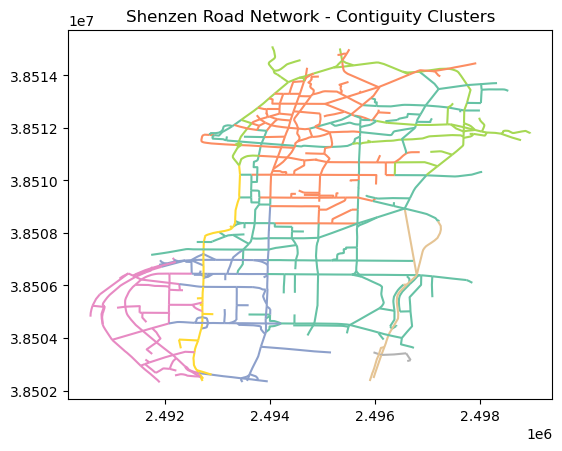

In [15]:
ax = gdf.plot(aspect=.5, column='Cluster_Contiguity', cmap = 'Set2')
ax.set_title("Shenzen Road Network - Contiguity Clusters")
ax.plot()

[]

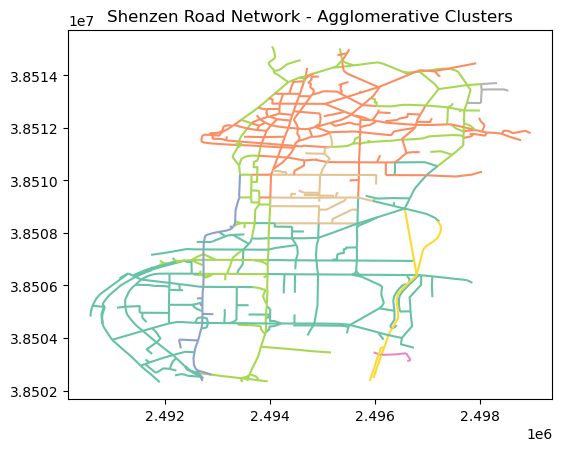

In [16]:
ax = gdf.plot(aspect=.5, column='Cluster_Agglomerative', cmap = 'Set2')
ax.set_title("Shenzen Road Network - Agglomerative Clusters")
ax.plot()

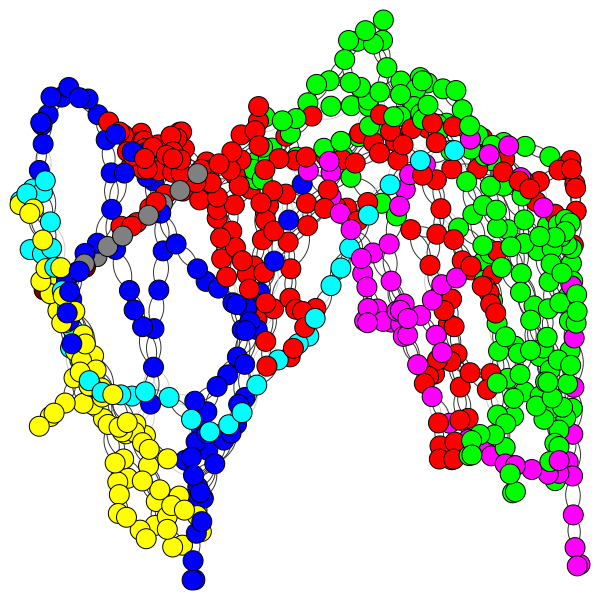

In [4]:
ig.plot(contiguity_clustering_results[param]['Partition'])

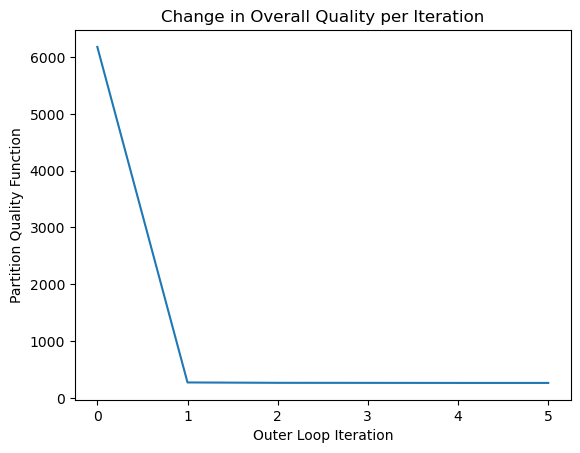

In [48]:
import matplotlib.pyplot as plt

iters = list(range(len(contiguity_clustering_results[param]['Raw_Quality'])))
plt.plot(iters, contiguity_clustering_results[param]['Raw_Quality'])
plt.title('Change in Overall Quality per Iteration')
plt.xlabel('Outer Loop Iteration')
plt.ylabel('Partition Quality Function')
plt.show()

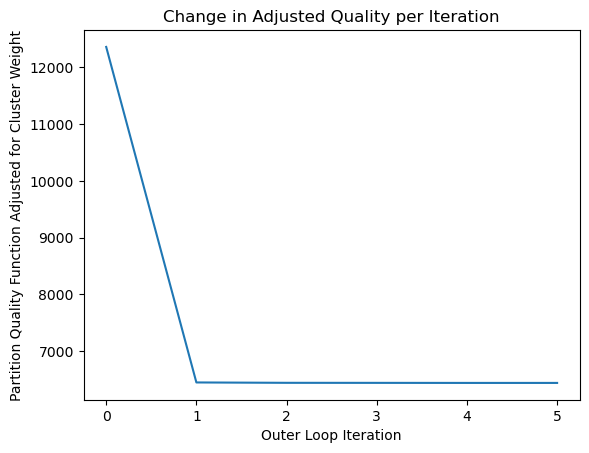

In [49]:
plt.plot(iters, contiguity_clustering_results[param]['Adjusted_Quality'])
plt.title('Change in Adjusted Quality per Iteration')
plt.xlabel('Outer Loop Iteration')
plt.ylabel('Partition Quality Function Adjusted for Cluster Weight')
plt.show()

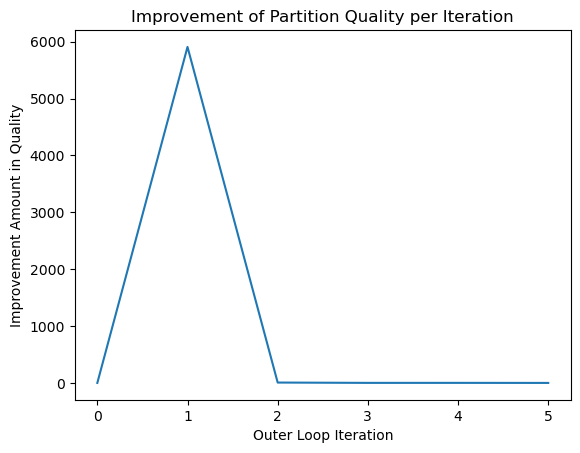

In [50]:
plt.plot(iters, contiguity_clustering_results[param]['Diffs'])
plt.title('Improvement of Partition Quality per Iteration')
plt.xlabel('Outer Loop Iteration')
plt.ylabel('Improvement Amount in Quality')
plt.show()

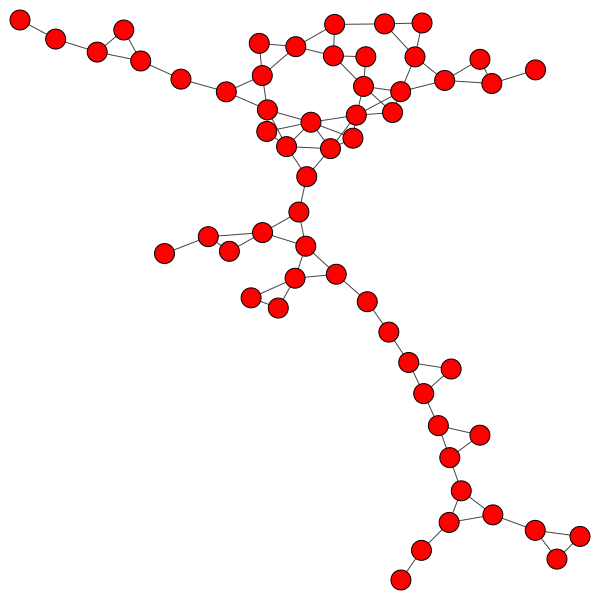

In [27]:
param = 5
results_map = contiguity_clustering_results[param]
find_disconnected_communities(results_map)
subgraph_edges, subgraph_vertices = get_subgraphs_by_clusters(results_map['Edge_Matrix_DF'], results_map['Partition'])
graph_number = 3
ig.plot(ig.Graph(n=len(subgraph_vertices[graph_number]), edges=subgraph_edges[graph_number], directed=False))


# Comparing Runtime Performance

In [17]:
import igraph as ig
import leidenalg
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import time

def perform_partition(partition, optimiser, n_iterations):
    itr = 0 
    continue_iteration = itr < n_iterations or n_iterations < 0
    while continue_iteration:
        diff_inc = leidenalg._c_leiden._Optimiser_optimise_partition(
            optimiser._optimiser,
            partition._partition,
        )   
        itr += 1

        if n_iterations < 0:
            continue_iteration = (diff_inc > 0)
        else:
            continue_iteration = itr < n_iterations

    partition._update_internal_membership()
    return partition, optimiser

def compare_runtime_performance(param, num_repeat):
    edge_map, node_attributes = parse_shenzen_info()
    edge_matrix = pd.DataFrame(columns=('Source','Target'), data=edge_map)
    scaler = StandardScaler()
    node_attributes = np.array(node_attributes).reshape(-1, 1).tolist()
    X = scaler.fit_transform(node_attributes).tolist()
    
    elapsed_contiguity = []
    elapsed_agglomerative = []

    for _ in range(num_repeat):
        graph = ig.Graph.DataFrame(edge_matrix)
        kwargs = {
            'node_attributes':X,
            'resolution_parameter': param,
            'disconnect_penalty':0
        }
        partition = leidenalg.ContiguousConstrainedVertexPartition(graph=graph, **kwargs)
        optimiser = leidenalg.Optimiser()
        
        start = time.perf_counter()
        perform_partition(partition, optimiser, -1)
        elapsed_contiguity.append(time.perf_counter() - start)

        connectivity_matrix = convert_edge_matrix_to_connectivity_matrix(edge_matrix)
        
        start = time.perf_counter()
        agg_clustering = AgglomerativeClustering(n_clusters=8, linkage='ward', metric='euclidean', connectivity=connectivity_matrix, compute_distances=True)
        agg_clustering.fit(node_attributes)
        elapsed_agglomerative.append(time.perf_counter() - start)
    
    return elapsed_contiguity, elapsed_agglomerative


In [18]:
param = 10
num_repeat = 100
elapsed_contiguity, elapsed_agglomerative = compare_runtime_performance(param, num_repeat)
mean_contiguity = sum(elapsed_contiguity)/len(elapsed_contiguity)
mean_agglomerative = sum(elapsed_agglomerative)/len(elapsed_agglomerative)
print('-'*100)
print(f'Mean runtime of contiguous partitioning method over {num_repeat} runs: {mean_contiguity}s')
print(f'Mean runtime of aggomerative ward method       over {num_repeat} runs: {mean_agglomerative}s')

----------------------------------------------------------------------------------------------------
Mean runtime of contiguous partitioning method over 100 runs: 1.1661740616249154s
Mean runtime of aggomerative ward method       over 100 runs: 0.030187614890746773s


# Comparing with Modularity Clustering

In [76]:
def manually_optimize_modularity(edge_matrix, resolution_parameter, n_iterations):
    graph = ig.Graph.DataFrame(
        edges=edge_matrix, 
        directed=False, 
    )
    partition = leidenalg.CPMVertexPartition(graph, resolution_parameter=resolution_parameter)
    optimiser = leidenalg.Optimiser()

    historic_raw_qualities = []
    historic_qualities = []
    historic_community_weights = []
    historic_diffs = []
    move_history = []
    collapse_history = []

    itr = 0 
    diff = 0
    continue_iteration = itr < n_iterations or n_iterations < 0
    while continue_iteration:
        diff_inc = leidenalg._c_leiden._Optimiser_optimise_partition(
            optimiser._optimiser,
            partition._partition,
        )   
        partition._update_internal_membership()
        itr += 1
        raw_quality = partition.quality()
        num_clusters = len(partition)
        adjusted_quality = 0
        diff += diff_inc

        historic_raw_qualities.append(raw_quality)
        historic_qualities.append(adjusted_quality)
        historic_community_weights.append(num_clusters)
        historic_diffs.append(diff_inc)

        per_collapse_history_this_iteration = optimiser.get_optimization_history_per_collapse()
        collapse_history.extend(per_collapse_history_this_iteration)
        per_move_history_this_iteration = analyze_per_move_history(optimiser.get_optimization_history_per_move(), itr)
        move_history.extend(per_move_history_this_iteration)

        if n_iterations < 0:
            continue_iteration = (diff_inc > 0)
        else:
            continue_iteration = itr < n_iterations

    return partition, optimiser, historic_raw_qualities, historic_qualities, historic_community_weights, historic_diffs, collapse_history, move_history

def get_modularity_custering_results():
    edge_map, node_attributes = parse_shenzen_info()
    edge_matrix = pd.DataFrame(columns=('Source','Target'), data=edge_map)
    possible_params = [.0045]
    scaler = StandardScaler()
    node_attributes = np.array(node_attributes).reshape(-1, 1).tolist()
    X = scaler.fit_transform(node_attributes).tolist()
    
    results = {}

    for param in possible_params:
        partition, optimiser, raw_quality, qualities, community_weights, diffs, collapse_history, move_history = manually_optimize_modularity(
            edge_matrix=edge_matrix, 
            resolution_parameter=param,
            n_iterations=2
        )
        clustering = perform_agglomerative_clustering(edge_matrix=edge_matrix, node_attributes=X, num_clusters=len(partition.sizes()))
        output_df = compare_clustering_result(node_attributes=X, partition=partition, clusters=clustering, param=param)
        results[param] = {
            'Partition':partition, 
            'Optimiser': optimiser,
            'Clustering':clustering, 
            'Raw_Quality':raw_quality, 
            'Adjusted_Quality':qualities, 
            'Community_Weight':community_weights, 
            'Diffs':diffs,
            'Output_DF':output_df,
            'Collapse_History':collapse_history,
            'Move_History':move_history,
            'Edge_Matrix_DF':edge_matrix
        }
    
    return results

In [77]:
modularity_clustering_results = get_modularity_custering_results()

----------------------------------------------------------------------------------------------------
Clustering Analysis
----------------------------------------------------------------------------------------------------
Clustering with 618 elements and 8 clusters
Partition quality: -4618.062
Weighted speed variance of contiguity based clusters:    531.939600429628
Silhouette Score: -0.3533745209045873
Calinski-Harabasz Index: 14.098497459788746
Davies-Bouldin Index: 14.371237277369573
----------------------------------------------------------------------------------------------------
Agglomerative clustering on 8 clusters: 
Sum of distances: 350.4359874664629
Weighted speed variance of agglomerative based clusters: 204.6072529874296
Silhouette Score: -0.06444083587135024
Calinski-Harabasz Index: 176.06523996987985
Davies-Bouldin Index: 3.6629696774629563


In [21]:
get_shenzen_clustering_results([10])

----------------------------------------------------------------------------------------------------
Clustering Analysis
----------------------------------------------------------------------------------------------------
Clustering with 618 elements and 8 clusters
Partition quality: 182.0394820751335
Weighted speed variance of contiguity based clusters:    182.03948207513366
Silhouette Score: -0.038673305944624765
Calinski-Harabasz Index: 208.6956340480719
Davies-Bouldin Index: 4.2489751779214995
----------------------------------------------------------------------------------------------------
Agglomerative clustering on 8 clusters: 
Sum of distances: 350.4359874664629
Weighted speed variance of agglomerative based clusters: 204.6072529874296
Silhouette Score: -0.06444083587135024
Calinski-Harabasz Index: 176.06523996987985
Davies-Bouldin Index: 3.6629696774629563


{10: {'Partition': <leidenalg.VertexPartition.ContiguousConstrainedVertexPartition at 0x126d98710>,
  'Optimiser': <leidenalg.Optimiser.Optimiser at 0x126dc3310>,
  'Clustering': AgglomerativeClustering(compute_distances=True,
                          connectivity=array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 1., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.]]),
                          metric='euclidean', n_clusters=8),
  'Raw_Quality': [6180.0,
   270.34026110581493,
   263.83544591051435,
   263.0236320524815,
   262.0394820751335,
   262.0394820751335],
  'Adjusted_Quality': [12360.0,
   6450.3402611058145,
   6443.835445910514,
   6443.023632052482,
   6442.0394820751335,
   6442.0394820751335],
  'Community_Weight': [618, 618, 618, 618, 618, 618],
  'Diffs': [0,
   5909.6597388941855,
   6.5048151953005835,
   0.81181385803277

In [72]:
import geopandas as gpd
import fiona

gdf_modular = gpd.read_file('./data/shenzhen_roads.geojson')
gdf_modular['Cluster_Contiguity'] = modularity_clustering_results[.0045]['Partition'].membership

<Axes: >

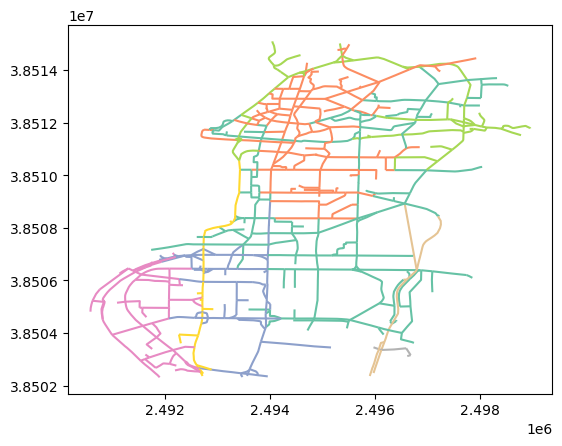

In [73]:
gdf.plot(aspect=.5, column='Cluster_Contiguity', cmap = 'Set2')

# Analyzing Move History

In [81]:
move_history = contiguity_clustering_results[param]['Move_History']
move_history_df = pd.DataFrame(move_history)
reassignment_history = results_map['Reassignment_History']

moves_phase_subset = move_history_df
assignments_phase_subset = reassignment_history
joined_df = moves_phase_subset.merge(
    right=assignments_phase_subset,
    left_on=['to_community_id', 'phase'],
    right_on=['Old_Comm', 'Phase'],
    how='left'
)

NameError: name 'results_map' is not defined

In [18]:
move_history_df[move_history_df['move_type'] == 'merge_constrained']

,move_type,phase,node_id,from_community_id,to_community_id,diff_move,iteration
712,merge_constrained,refine_phase_1.0,117.0,117.0,116.0,499.998607,1
713,merge_constrained,refine_phase_1.0,512.0,512.0,513.0,499.980950,1
714,merge_constrained,refine_phase_1.0,301.0,301.0,302.0,499.963283,1
715,merge_constrained,refine_phase_1.0,340.0,340.0,124.0,499.357490,1
716,merge_constrained,refine_phase_1.0,564.0,564.0,565.0,499.990459,1
717,merge_constrained,refine_phase_1.0,240.0,240.0,77.0,499.999830,1
718,merge_constrained,refine_phase_1.0,43.0,43.0,44.0,499.976560,1
719,merge_constrained,refine_phase_1.0,79.0,79.0,540.0,499.953622,1
720,merge_constrained,refine_phase_1.0,582.0,582.0,583.0,499.997120,1
721,merge_constrained,refine_phase_1.0,193.0,193.0,600.0,499.971061,1


In [11]:
move_history_df[move_history_df['node_id'] == 168]

,move_type,phase,node_id,from_community_id,to_community_id,diff_move,iteration
433,move,move_phase_1.0,168.0,168.0,567.0,497.169149,1
1289,merge_constrained,refine_phase_2.0,168.0,168.0,156.0,499.999539,1


In [12]:
target_comm = 10
joined_df[
    # (joined_df['from_community_id'] == target_comm) | 
    # (joined_df['to_community_id'] == target_comm) | 
    # (joined_df['Old_Comm'] == target_comm) |
    # (joined_df['New_Comm'] == target_comm)
    (joined_df['node_id'] == 168)
]

,move_type,phase,node_id,from_community_id,to_community_id,diff_move,iteration,Old_Comm,New_Comm,Move_Type,Phase
433,move,move_phase_1.0,168.0,168.0,567.0,497.169149,1,567.0,158.0,move,move_phase_1.0
1289,merge_constrained,refine_phase_2.0,168.0,168.0,156.0,499.999539,1,156.0,73.0,merge_constrained,refine_phase_2.0


In [17]:
target_comm = 28
joined_df[
    (joined_df['from_community_id'] == target_comm) | 
    (joined_df['to_community_id'] == target_comm) | 
    (joined_df['Old_Comm'] == target_comm) 
    # |
    # (joined_df['New_Comm'] == target_comm)
    # (joined_df['node_id'] == 168)
]

,move_type,phase,node_id,from_community_id,to_community_id,diff_move,iteration,Old_Comm,New_Comm,Move_Type,Phase
357,move,move_phase_1.0,28.0,28.0,162.0,499.962721,1,162.0,8.0,move,move_phase_1.0
955,merge_constrained,refine_phase_1.0,28.0,28.0,264.0,499.998427,1,264.0,14.0,merge_constrained,refine_phase_1.0
1129,move,move_phase_2.0,212.0,28.0,159.0,0.331244,1,159.0,47.0,move,move_phase_2.0
1218,move,move_phase_2.0,12.0,28.0,64.0,499.810927,1,64.0,5.0,move,move_phase_2.0
1341,merge_constrained,refine_phase_2.0,128.0,128.0,28.0,499.765049,1,28.0,20.0,merge_constrained,refine_phase_2.0
1376,merge_constrained,refine_phase_2.0,131.0,131.0,28.0,499.082908,1,28.0,20.0,merge_constrained,refine_phase_2.0
1495,merge_constrained,refine_phase_3.0,79.0,79.0,28.0,490.056802,1,28.0,23.0,merge_constrained,refine_phase_3.0
1562,merge_constrained,refine_phase_4.0,12.0,12.0,28.0,494.381375,1,28.0,11.0,merge_constrained,refine_phase_4.0


In [6]:
output_df = contiguity_clustering_results[500]['Output_DF']
output_df[output_df['Cluster_Contiguity'] == 10]

,Speed,Squared_Speed,Cluster_Agglomerative,Cluster_Contiguity
48,0.416764,0.173692,3,10
168,0.184137,0.033906,3,10


# Generating Sample Dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

def get_test_clustering_results():
    rng = np.random.default_rng()
    dataset_size = 50

    combo = np.vstack((rng.normal(20, size=(dataset_size, 1)),
                    rng.normal(15, size=(dataset_size, 1)),
                    rng.normal(10, size=(dataset_size, 1)),
                    rng.normal(5, size=(dataset_size, 1)),
                    rng.normal(0, size=(dataset_size, 1)),))

    source = np.arange(0,dataset_size * 5)
    target = np.arange(0,dataset_size * 5) + 1
    edge_matrix = pd.DataFrame(data={'Source':source, 'Target':target})
    edge_matrix = edge_matrix.drop(dataset_size * 5 - 1, axis=0)

    possible_params = [10]
    scaler = StandardScaler()
    node_attributes = combo.reshape(-1, 1).tolist()
    X = scaler.fit_transform(node_attributes).tolist()
    
    data = (edge_matrix, combo)
    results = {}

    for param in possible_params:
        partition, optimiser, raw_quality, qualities, community_weights, diffs, collapse_history, move_history = manually_optimize_partition(
            edge_matrix=edge_matrix, 
            node_attributes=X, 
            resolution_parameter=param,
            n_iterations=2,
            disconnect_penalty=0
        )
        clustering = perform_agglomerative_clustering(edge_matrix=edge_matrix, node_attributes=X, num_clusters=len(partition.sizes()))
        output_df = compare_clustering_result(node_attributes=X, partition=partition, clusters=clustering, param=param)
        results[param] = {
            'Partition':partition, 
            'Optimiser': optimiser,
            'Clustering':clustering, 
            'Raw_Quality':raw_quality, 
            'Adjusted_Quality':qualities, 
            'Community_Weight':community_weights, 
            'Diffs':diffs,
            'Output_DF':output_df,
            'Collapse_History':collapse_history,
            'Move_History':move_history,
            'Edge_Matrix_DF':edge_matrix
        }
    
    
    return results, data

In [3]:
test_results, test_data = get_test_clustering_results()

----------------------------------------------------------------------------------------------------
Clustering Analysis
----------------------------------------------------------------------------------------------------
Clustering with 250 elements and 5 clusters
Partition quality: 5.128104523008602
Weighted speed variance of contiguity based clusters:    5.128104523008567
Silhouette Score: 0.7135081144302714
Calinski-Harabasz Index: 2924.7460793108653
Davies-Bouldin Index: 0.34589221332625625
----------------------------------------------------------------------------------------------------
Agglomerative clustering on 5 clusters: 
Sum of distances: 77.90622369480033
Weighted speed variance of agglomerative based clusters: 5.128104523008567
Silhouette Score: 0.7135081144302714
Calinski-Harabasz Index: 2924.7460793108653
Davies-Bouldin Index: 0.3458922133262562


In [34]:
test_results[10]['Output_DF']

,Speed,Squared_Speed,Cluster_Agglomerative,Cluster_Contiguity
0,1.499277,2.247831,29,15
1,1.067448,1.139446,30,15
2,1.455142,2.117438,11,15
3,1.447042,2.093931,11,15
4,1.306966,1.708160,11,15
...,...,...,...,...
245,-1.769868,3.132433,17,12
246,-1.418615,2.012470,9,12
247,-1.316826,1.734032,9,12
248,-1.539495,2.370044,9,26


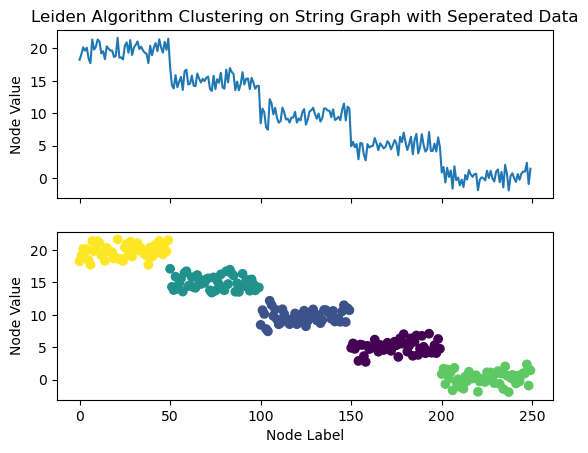

In [25]:
import matplotlib.pyplot as plt

figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)

ax1.plot(list(range(len(test_data[1]))), test_data[1])
ax2.scatter(list(range(len(test_data[1]))), test_data[1], c=test_results[10]['Output_DF']['Cluster_Contiguity'])
ax1.set_title("Leiden Algorithm Clustering on String Graph with Seperated Data")
ax2.set_xlabel('Node Label')
ax2.set_ylabel('Node Value')
ax1.set_ylabel('Node Value')

plt.savefig('simple_leidenalg_example.png')

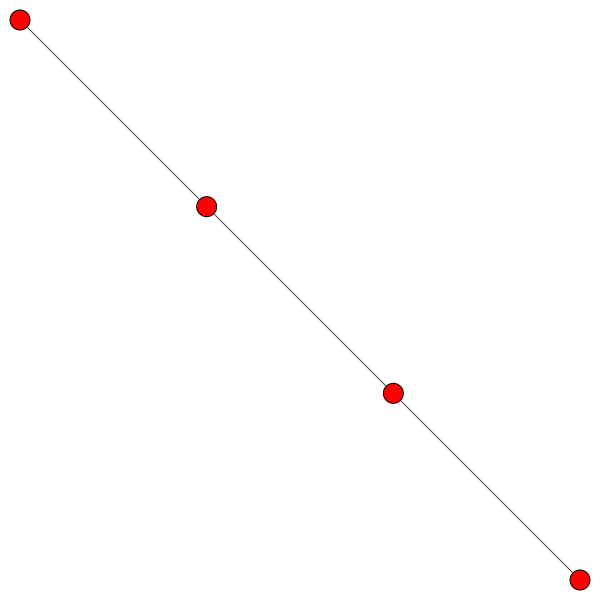

In [59]:
param = 10
results_map = test_results[param]
find_disconnected_communities(results_map)
subgraph_edges, subgraph_vertices = get_subgraphs_by_clusters(results_map['Edge_Matrix_DF'], results_map['Partition'])
graph_number = 12
ig.plot(ig.Graph(n=len(subgraph_vertices[graph_number]), edges=subgraph_edges[graph_number], directed=False))


# Tune from previous agglomeration

In [10]:
import igraph as ig
import leidenalg
import json
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

def manually_optimize_partition_with_starting_clusters(clusters: AgglomerativeClustering, edge_matrix, node_attributes, resolution_parameter, n_iterations):
    graph = ig.Graph.DataFrame(
        edges=edge_matrix, 
        directed=False, 
    )
    kwargs = {
        'node_attributes':node_attributes,
        'resolution_parameter':resolution_parameter
    }
    partition = leidenalg.ContiguousConstrainedVertexPartition(graph, **kwargs)
    partition.set_membership(clusters.labels_)
    optimiser = leidenalg.Optimiser()

    historic_raw_qualities = []
    historic_qualities = []
    historic_community_weights = []
    historic_diffs = []
    move_history = []
    collapse_history = []

    itr = 0 
    diff = 0
    continue_iteration = itr < n_iterations or n_iterations < 0
    while continue_iteration:
        diff_inc = leidenalg._c_leiden._Optimiser_optimise_partition(
            optimiser._optimiser,
            partition._partition,
        )   
        partition._update_internal_membership()
        itr += 1
        raw_quality = partition.quality()
        num_clusters = len(partition)
        community_weight = num_clusters * resolution_parameter
        adjusted_quality = (raw_quality *-1) + community_weight
        diff += diff_inc

        historic_raw_qualities.append(raw_quality)
        historic_qualities.append(adjusted_quality)
        historic_community_weights.append(num_clusters)
        historic_diffs.append(diff_inc)

        per_collapse_history_this_iteration = optimiser.get_optimization_history_per_collapse()
        collapse_history.extend(per_collapse_history_this_iteration)
        per_move_history_this_iteration = analyze_per_move_history(optimiser.get_optimization_history_per_move(), itr)
        move_history.extend(per_move_history_this_iteration)

        if n_iterations < 0:
            continue_iteration = (diff_inc > 0)
        else:
            continue_iteration = itr < n_iterations

    return partition, optimiser, historic_raw_qualities, historic_qualities, historic_community_weights, historic_diffs, collapse_history, move_history


def get_contiguity_clustering_from_agglomerative():
    edge_map, node_attributes = parse_shenzen_info()
    edge_matrix = pd.DataFrame(columns=('Source','Target'), data=edge_map)
    possible_params = [10]
    scaler = StandardScaler()
    node_attributes = np.array(node_attributes).reshape(-1, 1).tolist()
    X = scaler.fit_transform(node_attributes).tolist()
    
    desired_num_clusters = 10

    results = {}

    for param in possible_params:
        clustering = perform_agglomerative_clustering(edge_matrix=edge_matrix, node_attributes=X, num_clusters=desired_num_clusters)
        
        partition, optimiser, raw_quality, qualities, community_weights, diffs, collapse_history, move_history = manually_optimize_partition_with_starting_clusters(
            clusters=clustering,
            edge_matrix=edge_matrix, 
            node_attributes=X, 
            resolution_parameter=param,
            n_iterations=1
        )
        
        output_df = compare_clustering_result(X, partition=partition, clusters=clustering)
        results[param] = {
            'Partition':partition, 
            'Optimiser': optimiser,
            'Clustering':clustering, 
            'Raw_Quality':raw_quality, 
            'Adjusted_Quality':qualities, 
            'Community_Weight':community_weights, 
            'Diffs':diffs,
            'Output_DF':output_df,
            'Collapse_History':collapse_history,
            'Move_History':move_history,
        }
    
    return results

In [11]:
contiguities_from_clusters = get_contiguity_clustering_from_agglomerative()

: 

: 

# Notes

In [ ]:
# Set initial partition
edge_map, node_attributes = parse_shenzen_info()
edge_matrix = pd.DataFrame(columns=('Source','Target'), data=edge_map)
possible_params = [500]
scaler = StandardScaler()
node_attributes = np.array(node_attributes).reshape(-1, 1).tolist()
X = scaler.fit_transform(node_attributes).tolist()
graph = ig.Graph.DataFrame(
        edges=edge_matrix, 
        directed=False, 
)
resolution_parameter = 500
kwargs = {
    'node_attributes':X,
    'resolution_parameter':resolution_parameter
}
partition = leidenalg.ContiguousConstrainedVertexPartition(graph, **kwargs)
refined_partition = leidenalg.ContiguousConstrainedVertexPartition(graph, **kwargs)
optimiser = leidenalg.Optimiser()
optimiser.set_rng_seed(42)
partition_agg = refined_partition.aggregate_partition()
optimiser = la.Optimiser()

while optimiser.move_nodes(partition_agg):

  # Get individual membership for partition
  partition.from_coarse_partition(partition_agg, refined_partition.membership)

  # Refine partition
  refined_partition = leidenalg.ContiguousConstrainedVertexPartition(graph, **kwargs)
  optimiser.merge_nodes_constrained(refined_partition, partition)

  # Define aggregate partition on refined partition
  partition_agg = refined_partition.aggregate_partition()

  # But use membership of actual partition
  aggregate_membership = [None] * len(refined_partition)
  for i in range(graph.vcount()):
    aggregate_membership[refined_partition.membership[i]] = partition.membership[i]
  partition_agg.set_membership(aggregate_membership)